# Анализ пользовательского поведения в мобильном приложении по продаже продуктов питания

**Цель проекта** - выяснить, как ведут себя пользователи мобильного приложения. 

**Задачи проекта:**

- Изучить воронку продаж. Узнать как пользователь доходит до совершения покупки;
- Проанализировать поэтапный путь пользователя до покупки;
- Провести исследование результатов A/A/B-эксперимента со шрифтами;
- Выяснить, какой шрифт лучше работает для пользователей.

## Шаг 1. Загрузим файл с данными и изучим общую информацию


In [1]:
#подключим нужные модули и библиотеки
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import math as mth

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
df.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Вывод:**

По первому взгляду на данные, необходимо сделать следующее:
- Привести название столбцов к рабочему и более удобному виду;
- Поменять типы данных в столбцах;
- Проверить датасет на пропуски и дубликаты;
- Для удобства, заменить название групп на "А1", "А2" и "B"
- Проверить, нет ли в данных пользователей, участвовавших в нескольких группах теста одновременно.

## Шаг 2. Подготовим данные

### Переименуем столбцы

In [5]:
# сделаем копию датасета
data = df.copy()

In [6]:
data.columns = ['event_name', 'user_id', 'dt', 'group']

### Приведем столбец с датой и временем к нужному типу и добавим столбец с датами

In [7]:
data['dt'] = pd.to_datetime(data['dt'], unit='s')

# Добавим поле с датой:
data['date'] = pd.to_datetime(data['dt'].dt.date)

### Поменяем название групп теста
246 и 247 — контрольные группы будут А1 и А2, а 248 — экспериментальная группой B.

In [8]:
# Напишем функцию
def rename_group(x):
    if x == 246:
        return 'A1'
    elif x == 247:
        return 'A2'
    elif x == 248:
        return 'B'
    else:
        return 'Unknown'

data['group'] = data['group'].apply(rename_group)
data

,event_name,user_id,dt,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,A2,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,A1,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,A1,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,A1,2019-08-07


In [9]:
# Проверим, есть ли группа "Unknown"?
data['group'].unique()

array(['A1', 'B', 'A2'], dtype=object)

### Проверим датасет на пропуски и дубликаты

In [10]:
data.isnull().sum()

event_name    0
user_id       0
dt            0
group         0
date          0
dtype: int64

In [11]:
data.duplicated().sum()

413

Обнаружено 413 дубликатов, посмотрим сколько это составляет в процентах

In [12]:
print(f"доля дубликатов {data.duplicated().sum()/data['user_id'].count():.2%}")

доля дубликатов 0.17%


In [13]:
# Удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

### Проверим, нет ли в данных пользователей, участвовавших в нескольких группах теста одновременно

In [14]:
# отберем данные по группам
group_a1 = data.query('group == "A1"') 
group_a2 = data.query('group == "A2"') 
group_b = data.query('group == "B"') 
  
# получим id пользователей, попавших в обе группы А1 - А2
group_intersections = list(np.intersect1d(group_a1['user_id'], group_a2['user_id']))
print(len(group_intersections))

# получим id пользователей, попавших в обе группы А1 - В
group_intersections = list(np.intersect1d(group_a1['user_id'], group_b['user_id']))
print(len(group_intersections))

# получим id пользователей, попавших в обе группы А2 - В
group_intersections = list(np.intersect1d(group_a2['user_id'], group_b['user_id']))
print(len(group_intersections))

0
0
0


**Выводы по шагу 2**

На этапе предобработки было сделано:

- Заданы новые имена столбцов;
- Добавлен столбец с датами;
- Изменены названия групп (246, 247, 248 - А1, А2, В);
- Удалены 413 дубликатов (0.2% данных);
- Проверено пересечение пользователей в группах. Пересекающиеся пользователи не обнаружены.

## Шаг 3. Изучим и проверим данные.

### Посмотрим, сколько всего событий в логе?

In [15]:
print('Всего событий:', data['event_name'].count())
print()
print('Вариантов событий:', data['event_name'].nunique(), data['event_name'].unique())

Всего событий: 243713

Вариантов событий: 5 ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


In [16]:
# посмотрим, как распределены события
data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

### Узнаем, сколько всего пользователей в логе?

In [17]:
print('Всего уникальных пользователей:', data['user_id'].nunique())

Всего уникальных пользователей: 7551


### Узнаем, сколько в среднем событий приходится на пользователя?

In [18]:
data.groupby('user_id')['event_name'].agg('count').median()

20.0

**Вывод:**

Поскольку в поведенческих данных пользователей часто бывают выбросы, то среднее посчитали через медиану. В среднем, на пользователя приходится 20 событий.

**Построим точечный график количества событий на пользователей, оценим выбросы и распределение в целом.**

                  user_id  events
5116  6304868067479728361    2307
147    197027893265565660    1998
3714  4623191541214045580    1768
5590  6932517045703054087    1439
1391  1754140665440434215    1221
2641  3337471580007169353    1186
6294  7738058666231999878     888
822   1055544042902443290     854
3801  4713748699910253089     824
6617  8118046800480174342     755


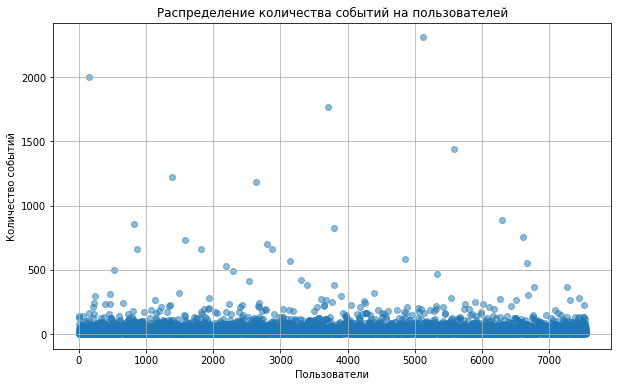

In [19]:
event_per_user = (
    data.groupby('user_id', as_index=False)
    .agg({'event_name': 'count'})
)
event_per_user.columns = ['user_id', 'events']

print(event_per_user.sort_values(by='events', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в event_per_user
x_values = pd.Series(range(0, len(event_per_user)))
plt.figure(figsize=(10, 6))
plt.scatter(x_values, event_per_user['events'], alpha=0.5)
plt.xlabel('Пользователи')
plt.ylabel('Количество событий')
plt.title('Распределение количества событий на пользователей')
plt.grid()
plt.show()

**Вывод**

На графике видим пользователей, на которых приходится более тысячи событий - просмотров страниц. Либо они настолько погружены в приложение, либо произошли технические неполадки при фиксировании их активности.

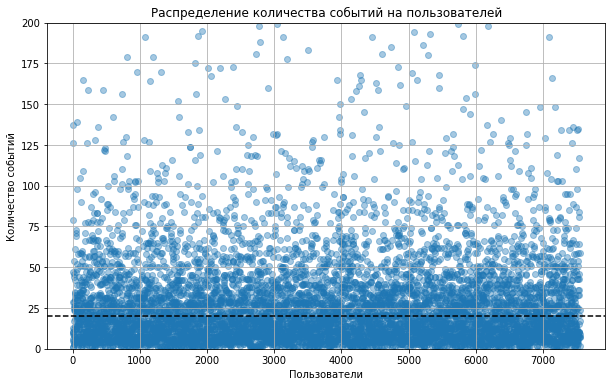

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(x_values, event_per_user['events'], alpha=0.4)
plt.xlabel('Пользователи')
plt.ylabel('Количество событий')
plt.title('Распределение количества событий на пользователей')
plt.ylim([0,200])
plt.axhline(y=20, color='black', linestyle='--') 
plt.grid()
plt.show()

В целом, можно понять, что для большинства пользователей количество событий не превышает 25.

### Узнаем, данными за какой период мы располагаем? 
Найдем максимальную и минимальную дату. 

Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Сделаем вывод о полноте данных за весь период. 

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Поймем, данными за какой период времени мы располагаем на самом деле?

#### Найдем максимальную и минимальную дату. 

In [21]:
print(f"Данные представлены с {data['date'].min()} по {data['date'].max()}")

Данные представлены с 2019-07-25 00:00:00 по 2019-08-07 00:00:00


#### Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Сделаем вывод о полноте данных за весь период. 

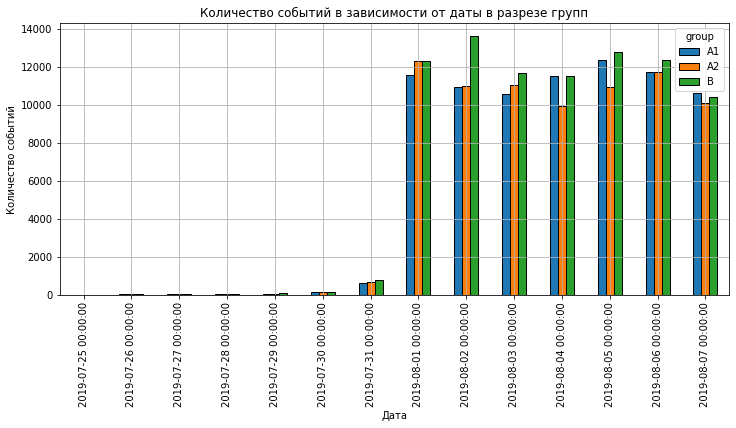

In [22]:
(data.pivot_table(index = 'date', columns = 'group', values = 'event_name', aggfunc = 'count')
 .plot(kind = 'bar', 
       title = 'Количество событий в зависимости от даты в разрезе групп', 
       xlabel = 'Дата', 
       ylabel = 'Количество событий', 
       figsize = (12,5),
       edgecolor = 'black',
       grid = True,
       legend = True)
)
None

**Вывод**

Видим, что хоть данные и представлены с 2019-07-25, но информационной ценности вплоть до 2019-08-01 они для нас не несут. Поэтому можем отбросить данные до этого периода. 

Акутальным и полезным для исследования периодом можем считать период с 2019-08-01 по 2019-08-07

In [23]:
data_new = data.query('dt >= "2019-08-01"').reset_index(drop=True)

### Рассмотрим, много ли событий и пользователей мы потеряли, отбросив старые данные?

In [24]:
lost_events = data['event_name'].count() - data_new['event_name'].count()
lost_events_per = lost_events / data['event_name'].count()
print(f"Потеряли {lost_events} событий, что составляет {lost_events_per:.2%}")

lost_users = data['user_id'].nunique() - data_new['user_id'].nunique()
lost_users_per = lost_users / data['user_id'].nunique()
print(f"Потеряли {lost_users} пользователей, что составляет {lost_users_per:.2%}")

Потеряли 2826 событий, что составляет 1.16%
Потеряли 17 пользователей, что составляет 0.23%


### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [25]:
data_new.groupby('group')['user_id'].nunique()

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

**Выводы по шагу 3:**

- Определили актуальный период для целей исследования - с 2019-08-01 по 2019-08-07
- Подчистили данные, потеряли 2826 событий, что составляет 1.2%, а также 17 пользователей, что составляет 0.2%.
- Выяснили, что после подчистки данных, у нас сохранились пользователи из трех экспериментальных групп. Количество участников которых в среднем находится на уровне 2500 человек.

## Шаг 4. Изучим воронку событий

### Посмотрим, какие события есть в логах, как часто они встречаются. 
Отсортируем события по частоте.

In [26]:
data_new

,event_name,user_id,dt,group,date
0,Tutorial,3737462046622621720,2019-08-01 00:07:28,A1,2019-08-01
1,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,A1,2019-08-01
2,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,A1,2019-08-01
3,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,A1,2019-08-01
4,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,A2,2019-08-01
...,...,...,...,...,...
240882,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,A2,2019-08-07
240883,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,A1,2019-08-07
240884,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,A1,2019-08-07
240885,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,A1,2019-08-07


In [27]:
data_new['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Для работы с событиями, следует разобраться с обозначениями событий:

- MainScreenAppear - Появление главной страницы приложения
- OffersScreenAppear - Появление страницы с предложениями
- CartScreenAppear - Появление страницы с корзиной клиента
- PaymentScreenSuccessful - Появление уведомления об успешной оплате покупок
- Tutorial - Инструкция по пользованию

Таким образом, мы видим, что наиболее популярное событие в логах - MainScreenAppear, появление главной страницы.
Наименее популярное событие - туториал.

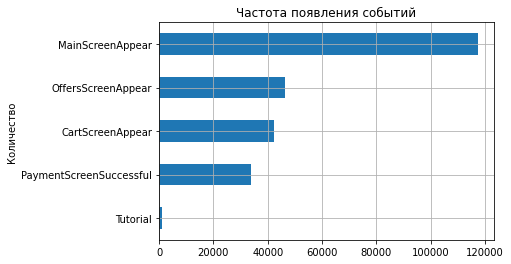

In [28]:
data_new['event_name'].value_counts(ascending = True).plot(
    kind = 'barh', 
    grid = True, 
    title = 'Частота появления событий', 
    ylabel = 'Количество')
None

### Посчитаем, сколько пользователей совершали каждое из этих событий. 
Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [29]:
event_user = data_new.pivot_table(
             index = 'event_name', 
             values = 'user_id', 
             aggfunc = 'nunique').sort_values(by='user_id', ascending= False).reset_index()

event_user.columns = ['event_name', 'count']

In [30]:
event_user['ratio'] = round(event_user['count']/data_new['user_id'].nunique()*100, 2)
event_user

,event_name,count,ratio
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


### Предположим, в каком порядке происходят события


**Вывод:**

Вырисовывается определенная последовательность, воронка.
1. Сначала человек попадает на главную страницу приложения (MainScreenAppear);
2. Далее переходит на страницу с предложениями (OffersScreenAppear);
3. Добавляет необходимое и переходит в корзину (CartScreenAppear);
4. Оплачивает заказ (CartScreenAppear).

Также, стоит отметить, что существует пункт с туториалом, т.е. инструкцией (Tutorial), но очевидно, что данный пункт не участвует непосредственно в воронке, а является необязательным пунктом, который можно скипнуть. Он идет после важного целевого действия - оплаты.

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [31]:

funnel = event_user[['event_name', 'count']]

# используем метод shift
funnel['shift'] = funnel['count'].shift(1, fill_value = funnel['count'].loc[funnel.index[0]])

funnel['conversion'] = round(funnel['count']/funnel['shift']*100, 1)

#в итоговой таблице оставим только количество уникальных пользователей и конверсией
funnel = funnel[['event_name', 'count', 'conversion']]
funnel

,event_name,count,conversion
0,MainScreenAppear,7419,100.0
1,OffersScreenAppear,4593,61.9
2,CartScreenAppear,3734,81.3
3,PaymentScreenSuccessful,3539,94.8
4,Tutorial,840,23.7


**Вывод:**

Наибольшая потеря клиентов случается на втором шаге - когда пользователь переходит с главной страницы на страницу с предложениями/товарами. Возможно, существуют технические проблемы при переходе.

In [34]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [7419, 4593, 3734, 3539],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous",
    marker = {"color": ["#016450", "#02818a", "#3690c0", "#fc9272"],
    "line": {"width": [3, 2, 2, 2], "color": ["white", "white", "white", "white"]}},
    connector = {"fillcolor": '#a6bddb'},
        insidetextfont = {'color': 'white', 'size': 14})
    )


fig.show()

**Выводы по шагу 3:**

Выявлена воронка событий для пользователя:
1. Сначала человек попадает на главную страницу приложения (MainScreenAppear);
2. Далее переходит на страницу с предложениями (OffersScreenAppear);
3. Добавляет необходимое и переходит в корзину (CartScreenAppear);
4. Оплачивает заказ (CartScreenAppear).

Наибольшая потеря клиентов случается на втором шаге - когда пользователь переходит с главной страницы на страницу с предложениями/товарами. На это могут оказывать влияние технические неполадки при загрузке страниц или же пользователям попросту неинтересны предложения от магазина. Однако 47.7 процентов пользователей проходят путь от главной страницы до оплаты.



## Шаг 5. Изучим результаты эксперимента


In [35]:
data_new.head(5)

,event_name,user_id,dt,group,date
0,Tutorial,3737462046622621720,2019-08-01 00:07:28,A1,2019-08-01
1,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,A1,2019-08-01
2,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,A1,2019-08-01
3,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,A1,2019-08-01
4,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,A2,2019-08-01


### Узнаем, сколько пользователей в каждой экспериментальной группе.

In [36]:
users_by_group = data_new.pivot_table(
    index = 'group',
    values = 'user_id',
    aggfunc = 'nunique').T
users_by_group

group,A1,A2,B
user_id,2484,2513,2537


В группе А1 - 2484 пользователя, в группе А2 - 2513 пользователей, в группе В - 2537 пользователей. Рамзеры групп слегка отличаются, следовательно в дальнейшем стоит улучшить механизм разделения пользователей.

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247 (между выборками А1 и А2)

In [37]:
group_test = data_new[data_new['event_name']!='Tutorial'].pivot_table(
             index = 'event_name',
             columns = 'group',
             values = 'user_id',
             aggfunc = 'nunique').reset_index().sort_values(by='A1', ascending=False)
group_test

group,event_name,A1,A2,B
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


Добавим воронку с разбивкой по группам и событиям. Сравним размеры групп на каждом этапе воронки.

In [38]:
from plotly import graph_objects as go

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А1',
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [2450, 1542, 1266, 1200],
    textinfo = "value+percent initial+percent previous",
    marker = {"color": "#016450"},
    insidetextfont = {'color': 'white', 'size': 10}))

fig.add_trace(go.Funnel(
    name = 'Группа А2',
    orientation = "h",
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [2476, 1520, 1238, 1158],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous",
    marker = {"color": "#3690c0"},
    insidetextfont = {'color': 'white', 'size': 10}))

fig.add_trace(go.Funnel(
    name = 'Группа В',
    orientation = "h",
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [2493, 1531, 1230, 1181],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous",
    marker = {"color": "#fc9272"},
    insidetextfont = {'color': 'white', 'size': 10}))

fig.show()

**Вывод:**

Видим, что группы примерно идентичны. Однако, группа А1 показывает лучшие показатели конверсии перехода от страницы к странице. 

Напишем функцию, которая позволит запускать тесты для разных событий и для разных групп.
Проведем А/А тестирование, это позволит нам оценить корректность расчетов для сравнений экспериментальных и контрольных групп. 


**Сформулируем нулевую и альтернативную гипотезы:**

**H0: различий в ĸонверсии перехода от одной страницы в воронĸе ĸ
следующей между группами А1 и А2 нет**

**H1: существуют статистическая разница в ĸонверсии перехода от одной страницы в воронĸе ĸ
следующей между группами А1 и А2.**

Для того, чтобы признать проведенное тестирование точным, нулевая гипотеза должна быть подтверждена, то есть различий между группами А1 и А2 быть не должно.

Уровень статистической значимости поставим на уровне 0.05.

Для тестов нам необходимо будет проводить сравнения долей генеральных совокупностей по выборкам из них. Разница между пропорциями, наблюдаемыми на выборках, будет нашей статистикой. Будем использовать Z-критерий двух пропорций. 

In [39]:
def test(group1, group2, alpha):
    for i in group_test.index:
        p1 = group_test[group1][i] / users_by_group[group1]
        # пропорция успехов во второй группе:
        p2 = group_test[group2][i] / users_by_group[group2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((group_test[group1][i] + group_test[group2][i]) / 
                      (users_by_group[group1] + users_by_group[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_by_group[group1] + 1/users_by_group[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(group_test['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        
test("A1", "A2", 0.05)

MainScreenAppear p-значение: [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: [0.24809546]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: [0.22883372]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: [0.11456679]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод**

По результатам теста видно, что p-значение больше заданного уровня статистической значимости, а значит между группами А1 и А2 нет статистически значимой разницы. Это говорит о том, что рассчеты корректны и мы можем сравнивать данные контрольные группы с экспериментальной. 

Также, стоит отметить, что поскольку тесты показали ожидаемый результат, то сложившееся разбиение на группы является корректным.

### Проверим, будет ли отличие между группами статистически значим для контрольных групп А1 и А2 с экспериментальной группой В.

**Сформулируем нулевую и альтернативную гипотезы:**

**H0: различий в ĸонверсии перехода от одной страницы в воронĸе ĸ
следующей между группами А1 и В нет**

**H1: существуют статистически значимая разница в ĸонверсии перехода от одной страницы в воронĸе ĸ
следующей между группами А1 и В.**

In [40]:
test("A1", "B", 0.05)

MainScreenAppear p-значение: [0.29497219]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: [0.20836205]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: [0.07842923]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: [0.21225533]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Сформулируем нулевую и альтернативную гипотезы:**

**H0: различий в ĸонверсии перехода от одной страницы в воронĸе ĸ
следующей между группами А2 и В нет**

**H1: существуют статистически значимая разница в ĸонверсии перехода от одной страницы в воронĸе ĸ
следующей между группами А2 и В.**

In [41]:
test("A2", "B", 0.05)

MainScreenAppear p-значение: [0.45870536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: [0.91978178]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: [0.57861979]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: [0.73734151]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Выводы:**

При поочередном сравнении двух контрольных групп А1, А2 с экспериментальной группой В, тесты не выявили статистически значимых различий. Причем для каждого события. 
Однако, стоит отметить, что при сравнении группы А2 с экспериментальной группой B p-значения для каждого события в тесте выше, чем при сравнении группы А1 с В. 

### Проведем тест для объединенной группы А1+А2 с экспериментальной группой В.

**Сформулируем нулевую и альтернативную гипотезы:**

**H0: различий в ĸонверсии перехода от одной страницы в воронĸе ĸ
следующей между объединенной группой А1+А2 и группой В нет**

**H1: существуют статистически значимая разница в ĸонверсии перехода от одной страницы в воронĸе ĸ
следующей между объединенной группой А1+А2 и группой В.**

Для теста, добавим данные для объединенной группы.

In [42]:
users_by_group['A1+A2'] = users_by_group['A1'] + users_by_group['A2']
users_by_group

group_test['A1+A2'] = group_test['A1'] + group_test['A2']
group_test

group,event_name,A1,A2,B,A1+A2
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
0,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [43]:
test("A1+A2", "B", 0.05)

MainScreenAppear p-значение: [0.29424527]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: [0.4342555]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: [0.18175875]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: [0.60042943]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:**

Как и в случае с предыдушими тестами, у нас нет оснований считать разницу между объединенными контрольными группами (А1+А2) и экспериментальной группой В статистически значимой, а это значит, что мы не можем отвергнуть нулевую гипотезу.

**Выводы по шагу 5:**

Было проведено 16 тестов, для каждого из 4 ключевых событий воронки (MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful).

Был задан ĸритичесĸий уровень статистичесĸой значимости alpha = 0.05, чтобы не увеличивать вероятность ошибки. 

Попарно сравнивались:
- А1/А2 группы
- А1/В группы
- А2/В группы
- А1+А2/В группы

Ни одна из проведенных проверок (из 16) не показала, что существует статистически значимая разница между группами. А это значит, что мы можем сделать вывод, что измение шрифта не оказало значимого влияния на поведение пользователей.



## Общие выводы.

**Исходя из структуры проекта, были получены следующие выводы по ключевым шагам:**

**1. Полученные для анализа данные были предобработаны.**

Сделано следующее:

- Для удобства работы изменены имена столбцов;
- Добавлен столбец с датами;
- Изменены названия групп (246, 247, 248 - А1, А2, В);
- Выявлены и удалены 413 явных дубликатов (0.2% данных);
- Проверено пересечение пользователей в группах. Пересекающиеся пользователи не были обнаружены.

Поскольку в данных были обнаружены дубликаты, возможно, стоит технически выяснить откуда они появились.

**2. Данные были проверены и изучены.**

Основные выводы:

- Определен актуальный период для целей исследования - с 2019-08-01 по 2019-08-07.
- Избавились от неинформативной части данных, удалены записи о 2826 событиях, что составляет 1.2%, а также о 17 пользователях, что составляет 0.2%.
- Определено, что после очистки данных, были сохранены пользователи из трех экспериментальных групп, количество участников которых в среднем находится на уровне 2500 человек.
- Определено, что в среднем на пользователя приходится 20 событий.

**3. Определена и изучена воронка событий.**

Основные выводы:

Воронка выглядит следующим образом:
1. Сначала человек попадает на главную страницу приложения (MainScreenAppear);
2. Далее переходит на страницу с предложениями (OffersScreenAppear);
3. Добавляет необходимое и переходит в корзину (CartScreenAppear);
4. Оплачивает заказ (CartScreenAppear).

- Наибольшая потеря клиентов случается на втором шаге - когда пользователь переходит с главной страницы на страницу с предложениями/товарами. Следует выяснить причину отскока, возможно существуют технические проблемы или предложения не сильно привлекают пользователей.
- 47.7 процентов пользователей проходят путь от главной страницы до оплаты.
- Наиболее популярное событие - MainScreenAppear - просмотр главного эĸрана приложения. Наиболее редĸое - Tutorial.

**4. Изучены результаты эксперимента и тестов.**

Было проведено 16 тестов, для каждого из 4 ключевых событий воронки (MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful).

Был задан ĸритичесĸий уровень статистичесĸой значимости alpha = 0.05, чтобы не увеличивать вероятность ошибки.

Попарно сравнивались:

А1/А2 группы

А1/В группы

А2/В группы

А1+А2/В группы

Ни одна из проведенных проверок (из 16) не показала, что существует статистически значимая разница между группами.

Таким образом, по результатам тестов мы не выявили значимого влияния нового шрифта на изменение поведения пользователей в приложении. А значит, что новый шрифт значительно не повлияет на поведение пользователей.